In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import os
from natsort import natsorted
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import math

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Preprocess Data

## Display Image

In [3]:
def display_image(inp_tensor, img_pos=0):
    """
    img_pos of 0 will get the middle image. img_pos -1 will get the img BEFORE the middle img, 1 will get the img AFTER the middle img, and so on.
    inp_tensor will be of shape [c, h, w]
    """
    num_channels = inp_tensor.shape[0]
    num_imgs = num_channels // 3
    middle_idx = num_imgs - 1 - (num_imgs // 2)
    selected_idx = middle_idx + img_pos

    img = inp_tensor[3*selected_idx:3*selected_idx+3]
    img = torch.permute(img, (1, 2, 0))
    # img = img[:, :, [2, 1, 0]]
    plt.figure()
    # plt.imshow(img)
    plt.imshow(img.cpu().numpy())
    plt.show()

## Dataset

In [4]:
def pixels_away_gaussian(sigma):
    """
        given sigma, determine how many orthogonal pixels away floor(G(x, y)) is greater than or equal to 128
    """
    p = math.sqrt(-2 * sigma * sigma * math.log(128 / 255))
    return math.floor(p)

In [5]:
assert pixels_away_gaussian(10) == 11

In [6]:
def create_ball_patch(sigma):
    p = pixels_away_gaussian(sigma)
        
    # create new patch
    one_row = np.zeros(p*2 + 1)
    for i in range(len(one_row)):
        one_row[i] = math.floor(((1/(2 * math.pi * sigma * sigma)) * math.exp(-((p - i) ** 2 ) / (2 * sigma * sigma))) * (2 * math.pi * sigma * sigma * 255)) / 255.0

    arr_rows = np.reshape(one_row, (len(one_row), 1))
    arr_cols = np.reshape(one_row, (1, len(one_row)))
    patch = np.multiply(arr_rows, arr_cols)
    patch = np.where(patch >= 0.5, patch, 0.0)
    patch = patch * 255.0
    patch = np.floor(patch)

    return patch

In [7]:
class TennisDataset(Dataset):
    def __init__(self, base_path, frames=1, resize=(360, 640), transform=None):
        self.base_path = base_path
        self.frames = frames
        self.resize = resize
        self.transform = v2.Compose([
            v2.Resize((resize[0], resize[1])),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        self.ball_patch = create_ball_patch(sigma=3)

        frames_ahead = frames // 2
        frames_behind = frames - 1 - frames_ahead

        data = []
        for game_name in natsorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in natsorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                # get labels, format their filenames, and combine them into one
                label_file_path = os.path.join(clip_path, 'Label.csv')
                label = pd.read_csv(label_file_path)
                label = label[frames_behind:-frames_ahead][:]
                label = label.fillna(-1)
                label = label.rename(columns={"file name": "filename"})
                label['filename'] = game_name + '_' + clip_name + '_' + label['filename']
                data.extend(label.values.tolist())

        self.labels = pd.DataFrame(data, columns=['filename', 'visibility', 'x-coordinate', 'y-coordinate', 'status'])
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgs = []
        label = self.labels.iloc[idx]
        
        filename = label.iloc[0]
        first_sep = filename.index("_")
        second_sep = filename.index("_", first_sep + 1)
        game_name = filename[:first_sep]
        clip_name = filename[first_sep+1:second_sep]
        img_num = int(filename[second_sep+1:filename.index(".")])

        frames_behind = self.frames - 1 - (self.frames // 2)
        start = img_num - frames_behind
        for i in range(start, start + self.frames):
            img_name = str(i).zfill(4) + ".jpg"
            img_path = os.path.join(self.base_path, game_name, clip_name, img_name)
            img = Image.open(img_path).convert('RGB')
            orig_w, orig_h = img.size
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = torch.cat(imgs, dim=0)

        # label consists of 'visibility', 'x-coordinate', 'y-coordinate', and 'status'
        label_vis = label.iloc[1]
        label_x = label.iloc[2]
        label_y = label.iloc[3]
        orig_x = label.iloc[2]
        orig_y = label.iloc[3]
        label_status = label.iloc[4]
        if label_x != -1:
            label_x = label_x * (self.resize[1] / orig_w)
        if label_y != -1:
            label_y = label_y * (self.resize[0] / orig_h)
        
        label = torch.tensor([label_vis, label_x, label_y, label_status], dtype=torch.float32)

        img_name = str(img_num).zfill(4) + ".jpg"
        path_gt = os.path.join(self.base_path, game_name, clip_name, img_name)
        gt_output = self.get_gt(path_gt, (label_x, label_y))

        return imgs, gt_output, label
    
    def get_gt(self, path_gt, ball_coord):
        img_x = self.resize[1]
        img_y = self.resize[0]
        (x, y) = ball_coord
        x = int(x)
        y = int(y)

        gt = np.zeros((self.resize[1], self.resize[0]), dtype=np.float32)
        if x == -1 or y == -1:
            return np.reshape(gt, self.resize[1] * self.resize[0])
        
        p = self.ball_patch.shape[0] // 2

        x1 = max(0, x - p)
        x2 = min(img_x, x + p + 1)
        y1 = max(0, y - p)
        y2 = min(img_y, y + p + 1)

        p1 = max(0, p - min(x, p))
        p2 = p1 + (x2 - x1)
        q1 = max(0, p - min(y, p))
        q2 = q1 + (y2 - y1)

        gt[x1:x2, y1:y2] = self.ball_patch[p1:p2, q1:q2]
        gt = np.reshape(gt, (640, 360))
        gt = np.rot90(gt, axes=(0, 1))
        gt = np.flip(gt, axis=0)
        
        return np.reshape(gt, self.resize[1] * self.resize[0])

## Dataloader

In [8]:
from torch.utils.data import DataLoader

In [9]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

batch_size = 2

In [10]:
base_path = './datasets/tennis'

In [11]:
full_dataset = TennisDataset(base_path, frames=3)

In [12]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Model

In [13]:
import torch.nn as nn

In [14]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.block(x)
        return x

class TrackNet(torch.nn.Module):
    def __init__(self, frames=1, out_channels=256):
        super().__init__()
        self.out_channels = out_channels
        self.VGG16 = nn.Sequential(
            ConvBlock(in_channels=frames*3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=256, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512)
        )
        self.DeconvNet = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=512, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=256, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=128, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            ConvBlock(in_channels=64, out_channels=self.out_channels)
        )
        
        self.init_weights()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.VGG16(x)
        x = self.DeconvNet(x)
        x = x.reshape(batch_size, self.out_channels, -1)
        return x

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                # nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

In [16]:
model = TrackNet(frames=3, out_channels=256).to(device)

## Hyperparameters

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
epochs = 100

e = 0

## Heatmap

In [18]:
def get_ball_xy(depth_indices, threshold=128):
    ret = []
    for indices in depth_indices:
        heatmap = torch.where(indices >= threshold, torch.tensor(255), torch.tensor(0))
        heatmap = torch.reshape(heatmap, (360, 640))
        heatmap = heatmap.detach().cpu().numpy().astype(np.uint8)
        blurred_heatmap = cv2.GaussianBlur(heatmap, (7, 7), 3)
        blurred_heatmap = blurred_heatmap.astype(np.uint8)
        circles = cv2.HoughCircles(blurred_heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=30, param2=6, minRadius=2, maxRadius=8)
        x, y = None, None
        
        if circles is not None:
            if circles.shape[1] != 1:
                ret.append((None, None))
                continue
            x = circles[0][0][0]
            y = circles[0][0][1]
        ret.append((x, y))

    return ret

## Train

In [19]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    
    for iter_id, (imgs, gt_output, label) in enumerate(train_loader):
        imgs = imgs.to(device)
        gt_output = gt_output.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        gt_output = gt_output.long()
        loss = criterion(outputs, gt_output)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss / (iter_id + 1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        batch_bar.update()

    batch_bar.close()
    return running_loss / len(train_loader)

## Validate

In [20]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = []
    dist = []
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]

    total_visibility = [0, 0, 0, 0]     # for debugging
    
    with torch.no_grad():
        for iter_id, (imgs, gt_output, label) in enumerate(val_loader):
            imgs = imgs.to(device)
            gt_output = gt_output.to(device)
            label = label.to(device)
            
            outputs = model(imgs)
            gt_output = gt_output.long()
            loss = criterion(outputs, gt_output)
            running_loss.append(loss.item())
            
            softmax_layers = nn.Softmax(dim=1)(outputs)
            depth_indices = torch.argmax(softmax_layers, dim=1)

            circles = get_ball_xy(depth_indices, threshold=128)
            for idx, (x, y) in enumerate(circles):
                visibility = int(label[idx][0].item())
                total_visibility[visibility] += 1
                x_coord = label[idx][1].item()
                y_coord = label[idx][2].item()
                status = int(label[idx][3].item())

                if not x or not y:
                    if visibility == 0:
                        tn[visibility] += 1
                    else:
                        fn[visibility] += 1
                else:
                    x_dist = (x_coord - x)**2
                    y_dist = (y_coord - y)**2
                    distance = np.sqrt(x_dist + y_dist)
                    
                    if visibility == 0 or distance >= 5.0:
                        fp[visibility] += 1
                    else:
                        tp[visibility] += 1
                        x_dist = (x_coord - x)**2
                        y_dist = (y_coord - y)**2
                        dist.append(np.sqrt(x_dist + y_dist))
            
    return np.mean(running_loss), np.mean(dist), tp, fp, tn, fn, total_visibility
            

## Debugging-ish

In [ ]:
features, gt_output, labels = next(iter(train_dataloader))

In [ ]:
i = 0

In [ ]:
print(features[i].shape)

In [ ]:
display_image(features[i])

# gt = torch.reshape(gt_output[i], (640, 360))
# gt = torch.rot90(gt, dims=[0, 1])
# gt = torch.flip(gt, dims=[0])
gt = torch.reshape(gt_output[i], (360, 640))
plt.imshow(gt, cmap='gray')
plt.show()

print(labels[i])

In [ ]:
model.eval()

with torch.no_grad():
    features = features.to(device)
    gt_output = gt_output.to(device)
    label = labels.to(device)

    outputs = model(features)
    

In [ ]:
softmax_layers = nn.Softmax(dim=1)(outputs)
depth_indices = torch.argmax(softmax_layers, dim=1)

In [ ]:
first_outputs = depth_indices[0]
first_outputs = torch.reshape(first_outputs, (360, 640))
first_outputs = first_outputs.detach().cpu().numpy()
plt.imshow(first_outputs, cmap='gray')

In [ ]:
circles = get_ball_xy(depth_indices, threshold=128)

for idx, (x, y) in enumerate(circles):
    print(f"actual (x, y): {label[idx][1].item()}, {label[idx][2].item()}")
    if not x or not y:
        print(f"x not found, or y not found")
    else:
        print(f"get_ball_xy (x, y): {x}, {y}")

In [ ]:
gt = gt.detach().cpu().numpy()

In [ ]:
blurred_heatmap = cv2.GaussianBlur(gt, (7, 7), 1.5)

In [ ]:
blurred_heatmap = blurred_heatmap.astype(np.uint8)
circles = cv2.HoughCircles(blurred_heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=30, param2=6, minRadius=2, maxRadius=8)

In [ ]:
plt.imshow(blurred_heatmap, cmap='gray')

In [ ]:
print(circles.shape[1])

In [ ]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(gt, cmap='gray')

for i in circles[0, :]:
    c = plt.Circle((i[0], i[1]), i[2], color='g', fill=False)
    ax.add_patch(c)

In [ ]:
gt = gt.detach().cpu().numpy()

In [ ]:
blurred_heatmap = cv2.GaussianBlur(gt, (7, 7), 1.5)

In [ ]:
circles = cv2.HoughCircles(image=blurred_heatmap, method=cv2.HOUGH_GRADIENT, 
                          dp=1, minDist=1, param1=30, param2=4,
                          minRadius=1, maxRadius=4)

In [ ]:
print(circles.shape)

In [ ]:
print(circles.shape[1])

In [ ]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(gt, cmap='gray')

# circle_idx = 5
# c = plt.Circle((circles[0, circle_idx, 0], circles[0, circle_idx, 1]), 
#                circles[0, circle_idx, 2], color='g', fill=False)
# ax.add_patch(c)

for i in circles[0, :]:
    c = plt.Circle((i[0], i[1]), i[2], color='g', fill=False)
    ax.add_patch(c)

plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    imgs = features.to(device)
    gt = gt_output.to(device)
    label = labels.to(device)

    outputs = model(imgs)

    softmax_layers = nn.Softmax(dim=1)(outputs)
    depth_indices = torch.argmax(softmax_layers, dim=1)

    depth_indices_second = depth_indices[i]
    second_reshaped = torch.reshape(depth_indices_second, (360, 640)).detach().cpu().numpy()
    plt.imshow(second_reshaped, cmap='gray')

In [ ]:
threshold = 128

In [ ]:
heatmap = torch.where(depth_indices_second >= threshold, torch.tensor(255), torch.tensor(0))
heatmap = torch.reshape(heatmap, (360, 640))

# ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
# heatmap = heatmap.reshape((360, 640))

In [ ]:
heatmap = heatmap.detach().cpu().numpy()

In [ ]:
plt.imshow(heatmap, cmap='gray');

In [ ]:
heatmap = heatmap.astype(np.uint8)

In [ ]:
circles = cv2.HoughCircles(image=heatmap, method=cv2.HOUGH_GRADIENT, 
                          dp=1, minDist=50, param1=50, param2=2,
                          minRadius=1, maxRadius=5)

In [ ]:
# circles = np.uint16(np.around(circles))
print(circles.shape)

In [ ]:
circles = np.uint16(np.around(circles))

# for i in circles[0, :]:
    # cv2.circle(heatmap, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # cv2.circle(heatmap, (i[0], i[1]), 2, (0, 0, 255), 3)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(heatmap, cmap='gray')

for i in circles[0, :]:
    c = plt.Circle((i[0], i[1]), i[2], color='g', fill=False)
    ax.add_patch(c)

plt.show()

In [ ]:
plt.imshow(heatmap, cmap='gray');

In [ ]:
heatmap = heatmap.astype(np.uint8)

In [ ]:
blurred_heatmap = cv2.GaussianBlur(heatmap, (7, 7), 1.5)

In [ ]:
plt.imshow(blurred_heatmap, cmap='gray')

In [ ]:
circles = cv2.HoughCircles(image=blurred_heatmap, method=cv2.HOUGH_GRADIENT,
                          dp=1, minDist=10, param1=50, param2=5,
                          minRadius=1, maxRadius=5)

In [ ]:
print(circles.shape)

In [ ]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(heatmap, cmap='gray')

# circle_idx = 3
# c = plt.Circle((circles[0, circle_idx, 0], circles[0, circle_idx, 1]), 
#                circles[0, circle_idx, 2], color='g', fill=False)
# ax.add_patch(c)

for i in circles[0, :]:
    c = plt.Circle((i[0], i[1]), i[2], color='g', fill=False)
    ax.add_patch(c)

plt.show()

## Training Loop

In [24]:
# best_dist = 5000.0

# best_f1 = 0.0
best_f1 = f1

for epoch in range(e, epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"epoch {epoch}, training loss: {train_loss}")
    val_loss, avg_dist, tp, fp, tn, fn, total_visibility = validate(model, val_dataloader, criterion, device)
    # val_loss = float("{:.2f}".format(val_loss))
    # avg_dist = float("{:.2f}".format(avg_dist))
    print(f"epoch: {epoch}, val loss: {val_loss}, avg_dist: {avg_dist}")
    print(f"tp: {tp}")
    print(f"fp: {fp}")
    print(f"tn: {tn}")
    print(f"fn: {fn}")
    print(f"tv: {total_visibility}")
    tp_total = sum(tp)
    fp_total = sum(fp)
    tn_total = sum(tn)
    fn_total = sum(fn)

    precision = tp_total / (tp_total + fp_total + 1)
    recall = tp_total / (sum(tp[-3:]) + sum(fp[-3:]) + sum(tn[-3:]) + sum(fn[-3:]) + 1)
    f1 = (2 * precision * recall) / (precision + recall + 1)
        
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1: {f1}")
    if f1 > best_f1:
        print("better model detected. saving model.")
        best_f1 = f1
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'f1': f1
        }, 'model.pth')

    if epoch % 2 == 0:
        print("saving...")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'f1': f1
        }, 'current_model.pth')

epoch 44, training loss: 0.00042020069710111785
epoch: 44, val loss: 0.0004650802743061115, avg_dist: 0.8713669776916504
tp: [0, 2399, 152, 3]
fp: [1, 2, 2, 0]
tn: [100, 0, 0, 0]
fn: [0, 229, 51, 8]
tv: [101, 2630, 205, 11]
precision: 0.99765625
recall: 0.8970846505093081
f1: 0.618350407943047
better model detected. saving model.
saving...


epoch 45, training loss: 0.00040818494164729857
epoch: 45, val loss: 0.00045670734468344497, avg_dist: 0.8553143739700317
tp: [0, 2420, 149, 2]
fp: [0, 2, 2, 0]
tn: [101, 0, 0, 0]
fn: [0, 208, 54, 9]
tv: [101, 2630, 205, 11]
precision: 0.9980590062111802
recall: 0.9030558482613277
f1: 0.6213494243975898
better model detected. saving model.


epoch 46, training loss: 0.000401493699913916
epoch: 46, val loss: 0.00047844655681928826, avg_dist: 0.879353940486908
tp: [0, 2386, 154, 4]
fp: [0, 3, 2, 0]
tn: [101, 0, 0, 0]
fn: [0, 241, 49, 7]
tv: [101, 2630, 205, 11]
precision: 0.9976470588235294
recall: 0.8935721812434141
f1: 0.6166738558666873
saving...


epoch 47, training loss: 0.0003935216884568627
epoch: 47, val loss: 0.0005444302877244216, avg_dist: 0.9278630614280701
tp: [0, 2339, 141, 2]
fp: [0, 1, 1, 0]
tn: [101, 0, 0, 0]
fn: [0, 290, 63, 9]
tv: [101, 2630, 205, 11]
precision: 0.9987927565392354
recall: 0.8717948717948718
f1: 0.606664917344529


epoch 48, training loss: 0.00038889695084093795
epoch: 48, val loss: 0.0004911884145433771, avg_dist: 0.8816553354263306
tp: [0, 2442, 147, 1]
fp: [0, 2, 1, 0]
tn: [101, 0, 0, 0]
fn: [0, 186, 57, 10]
tv: [101, 2630, 205, 11]
precision: 0.9984579799537394
recall: 0.9097295398665262
f1: 0.6246686037188646
better model detected. saving model.
saving...


epoch 49, training loss: 0.000381245983789718
epoch: 49, val loss: 0.0004651323859855963, avg_dist: 0.8610385060310364
tp: [0, 2450, 151, 3]
fp: [0, 0, 2, 0]
tn: [101, 0, 0, 0]
fn: [0, 180, 52, 8]
tv: [101, 2630, 205, 11]
precision: 0.998849252013809
recall: 0.9146469968387777
f1: 0.6271464869802993
better model detected. saving model.


epoch 50, training loss: 0.0003730433723745223
epoch: 50, val loss: 0.0005049519254086342, avg_dist: 0.9010003209114075
tp: [0, 2394, 158, 2]
fp: [2, 3, 2, 0]
tn: [99, 0, 0, 0]
fn: [0, 233, 45, 9]
tv: [101, 2630, 205, 11]
precision: 0.9968774395003903
recall: 0.8970846505093081
f1: 0.6180339766730147
saving...


epoch 51, training loss: 0.0003684885788813193
epoch: 51, val loss: 0.000490252361786178, avg_dist: 0.8848490715026855
tp: [0, 2423, 153, 5]
fp: [1, 2, 3, 0]
tn: [100, 0, 0, 0]
fn: [0, 205, 49, 6]
tv: [101, 2630, 205, 11]
precision: 0.9972952086553323
recall: 0.9065683175272217
f1: 0.6226988501606229


epoch 52, training loss: 0.0003635048147471184
epoch: 52, val loss: 0.0005266149874551929, avg_dist: 0.9060389995574951
tp: [0, 2358, 153, 2]
fp: [1, 3, 3, 0]
tn: [100, 0, 0, 0]
fn: [0, 269, 49, 9]
tv: [101, 2630, 205, 11]
precision: 0.9968266560888537
recall: 0.882683526519143
f1: 0.6111334305669149
saving...


epoch 53, training loss: 0.00035572796960102823
epoch: 53, val loss: 0.0005421002198441883, avg_dist: 0.9047898650169373
tp: [0, 2330, 153, 2]
fp: [0, 3, 1, 0]
tn: [101, 0, 0, 0]
fn: [0, 297, 51, 9]
tv: [101, 2630, 205, 11]
precision: 0.9979919678714859
recall: 0.87284861257464
f1: 0.6068577338988943


epoch 54, training loss: 0.00034939967705908135
epoch: 54, val loss: 0.0006263855642809148, avg_dist: 0.9422293901443481
tp: [0, 2179, 146, 5]
fp: [2, 4, 0, 0]
tn: [99, 0, 0, 0]
fn: [0, 447, 59, 6]
tv: [101, 2630, 205, 11]
precision: 0.9970047068891742
recall: 0.8184053389532842
f1: 0.5796342002008418
saving...


epoch 55, training loss: 0.000345418598009305
epoch: 55, val loss: 0.0005872905145919033, avg_dist: 0.9237551689147949
tp: [0, 2251, 144, 2]
fp: [1, 2, 2, 0]
tn: [100, 0, 0, 0]
fn: [0, 377, 59, 9]
tv: [101, 2630, 205, 11]
precision: 0.9975031210986267
recall: 0.8419388830347735
f1: 0.5915504964559379


epoch 56, training loss: 0.00033950663206637623
epoch: 56, val loss: 0.0005858715519958416, avg_dist: 0.9351767897605896
tp: [0, 2275, 144, 2]
fp: [0, 2, 1, 0]
tn: [101, 0, 0, 0]
fn: [0, 353, 60, 9]
tv: [101, 2630, 205, 11]
precision: 0.9983505154639175
recall: 0.8503688092729189
f1: 0.5960335451092454
saving...


Train:  22%|██▏       | 1521/6876 [07:16<25:20,  3.52it/s, loss=0.0003, lr=1.0000]

KeyboardInterrupt: 

## Load Model (and resume training)

In [21]:
model = TrackNet(frames=3, out_channels=256).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

In [22]:
checkpoint = torch.load('current_model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
e = checkpoint['epoch']
# f1 = checkpoint['f1']

best_model = torch.load('model.pth', weights_only=True)
f1 = best_model['f1']

In [23]:
model.train();

## Best Model (out of 50 epochs)

In [21]:
model = TrackNet(frames=3, out_channels=256).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

checkpoint = torch.load('model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
e = checkpoint['epoch']
f1 = checkpoint['f1']

model.eval();

In [35]:
features, gt, labels = next(iter(train_dataloader))

model.eval()

with torch.no_grad():
    features = features.to(device)
    gt = gt.to(device)
    label = labels.to(device)

    outputs = model(features)
    
softmax_layers = nn.Softmax(dim=1)(outputs)
depth_indices = torch.argmax(softmax_layers, dim=1)

In [36]:
circles = get_ball_xy(depth_indices, threshold=128)

for idx, (x, y) in enumerate(circles):
    print(f"actual (x, y): {label[idx][1].item()}, {label[idx][2].item()}")
    if not x or not y:
        print(f"x not found, or y not found")
    else:
        print(f"get_ball_xy (x, y): {x}, {y}")

actual (x, y): 356.0, 37.5
x not found, or y not found
actual (x, y): 252.0, 164.5
get_ball_xy (x, y): 252.5, 164.5


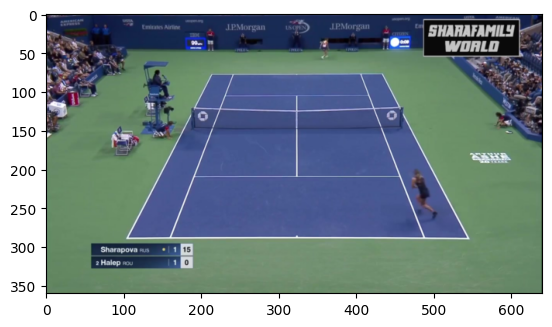

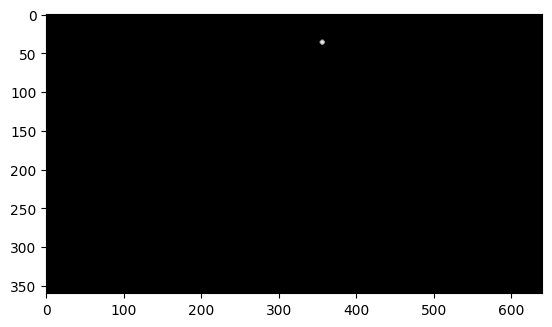

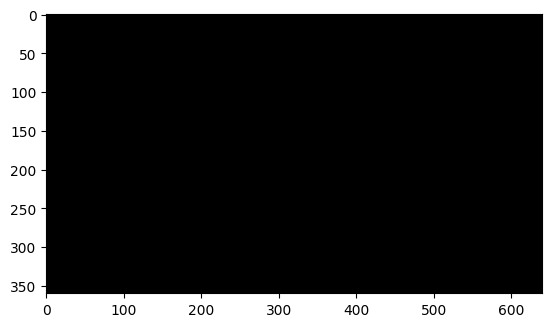

tensor([  1.0000, 356.0000,  37.5000,   0.0000])


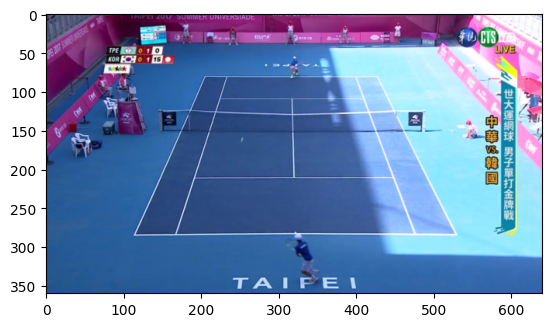

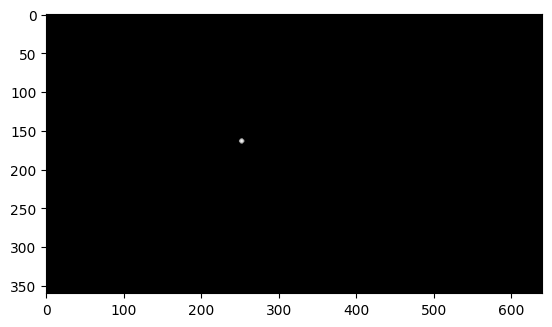

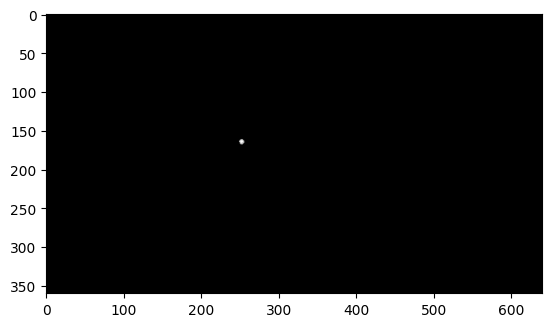

tensor([  1.0000, 252.0000, 164.5000,   0.0000])


In [37]:
for i, img in enumerate(features):
    display_image(features[i])

    # gt = torch.reshape(gt_output[i], (640, 360))
    # gt = torch.rot90(gt, dims=[0, 1])
    # gt = torch.flip(gt, dims=[0])
    gt_curr = torch.reshape(gt[i], (360, 640))
    gt_curr = gt_curr.detach().cpu().numpy()
    plt.imshow(gt_curr, cmap='gray')
    plt.show()

    display_depth_indices = torch.reshape(depth_indices[i], (360, 640))
    display_depth_indices = display_depth_indices.detach().cpu().numpy()
    plt.imshow(display_depth_indices, cmap='gray')
    plt.show()

    print(labels[i])

In [ ]:
problem_idx = 0

In [ ]:
problem_features = features[problem_idx]
problem_gt = gt[problem_idx]
problem_labels = labels[problem_idx]

In [ ]:
problem_outputs = outputs[problem_idx]
problem_softmax_layers = softmax_layers[problem_idx]
problem_depth_indices = depth_indices[problem_idx]

In [ ]:
blurred_img = torch.reshape(problem_depth_indices, (360, 640)).detach().cpu().numpy().astype(np.uint8)
blurred_img = cv2.GaussianBlur(blurred_img, (7, 7), 3)
blurred_img = blurred_img.astype(np.uint8)

plt.imshow(blurred_img, cmap='gray')

In [ ]:
def get_ball_xy(depth_indices, threshold=128):
    ret = []
    for indices in depth_indices:
        heatmap = torch.where(indices >= threshold, torch.tensor(255), torch.tensor(0))
        heatmap = torch.reshape(heatmap, (360, 640))
        heatmap = heatmap.detach().cpu().numpy().astype(np.uint8)
        blurred_heatmap = cv2.GaussianBlur(heatmap, (7, 7), 3)
        blurred_heatmap = blurred_heatmap.astype(np.uint8)
        circles = cv2.HoughCircles(blurred_heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=30, param2=6, minRadius=2, maxRadius=8)
        x, y = None, None
        
        if circles is not None:
            if circles.shape[1] != 1:
                ret.append((None, None))
                continue
            x = circles[0][0][0]
            y = circles[0][0][1]
        ret.append((x, y))

    return ret

In [ ]:
wrapped_p_d_i = [problem_depth_indices]

circles = get_ball_xy(wrapped_p_d_i, threshold=128)

circles = np.array(circles)
print(circles.shape)
print(circles[0][1])

In [22]:
val_loss, avg_dist, tp, fp, tn, fn, total_visibility = validate(model, test_dataloader, criterion, device)
print(f"val loss: {val_loss}, avg_dist: {avg_dist}")
print(f"tp: {tp}")
print(f"fp: {fp}")
print(f"tn: {tn}")
print(f"fn: {fn}")
print(f"tv: {total_visibility}")
tp_total = sum(tp)
fp_total = sum(fp)
tn_total = sum(tn)
fn_total = sum(fn)

precision = tp_total / (tp_total + fp_total + 1)
recall = tp_total / (sum(tp[-3:]) + sum(fp[-3:]) + sum(tn[-3:]) + sum(fn[-3:]) + 1)
f1 = (2 * precision * recall) / (precision + recall + 1)
        
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")

val loss: 0.000423400003117935, avg_dist: 0.7991707921028137
tp: [0, 2484, 139, 11]
fp: [0, 2, 0, 0]
tn: [106, 0, 0, 0]
fn: [0, 138, 63, 3]
tv: [106, 2624, 202, 14]
precision: 0.9988623435722411
recall: 0.9271383315733897
f1: 0.6330029753974415
